<a href="https://colab.research.google.com/github/ahmadbadawikr/DS_and_ML/blob/master/TFLite_TransferLearning_0(MobileNetv2).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from __future__ import absolute_import, division, print_function

import os

import matplotlib.pylab as plt
import numpy as np

import tensorflow as tf
import tensorflow_hub as hub

print('Version: ', tf.__version__)
print('Eager mode: ', tf.executing_eagerly())
print('Hub version: ', hub.__version__)
print('GPU is', 'available' if tf.test.is_gpu_available() else 'NOT AVAILABLE')

Version:  2.3.0
Eager mode:  True
Hub version:  0.9.0
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
GPU is NOT AVAILABLE


Select the Hub/TF2 module to use

In [3]:
module_selection = ("mobilenet_v2", 224, 1280) #@param ["(\"mobilenet_v2\", 224, 1280)", "(\"inception_v3\", 299, 2048)"] {type:"raw", allow-input: true}
handle_base, pixels, FV_SIZE = module_selection
MODULE_HANDLE ="https://tfhub.dev/google/tf2-preview/{}/feature_vector/4".format(handle_base)
IMAGE_SIZE = (pixels, pixels)
print("Using {} with input size {} and output dimension {}".format(
  MODULE_HANDLE, IMAGE_SIZE, FV_SIZE))

Using https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4 with input size (224, 224) and output dimension 1280


Data Preprocessing

In [4]:
import tensorflow_datasets as tfds
tfds.disable_progress_bar()

In [5]:
(train_examples, validation_examples, test_examples), info = tfds.load(
    'cats_vs_dogs',
    split=['train[80%:]', 'train[80%:90%]', 'train[90%:]'],
    with_info=True, 
    as_supervised=True, 
)

num_examples = info.splits['train'].num_examples
num_classes = info.features['label'].num_classes

/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Shuffling and writing examples to /root/tensorflow_datasets/cats_vs_dogs/4.0.0.incompleteDOTRM5/cats_vs_dogs-train.tfrecord
Dataset cats_vs_dogs downloaded and prepared to /root/tensorflow_datasets/cats_vs_dogs/4.0.0. Subsequent calls will reuse this data.


Format the Data

In [6]:
def format_image(image, label):
  image = tf.image.resize(image, IMAGE_SIZE) / 255.0
  return  image, label

In [7]:
BATCH_SIZE = 32

In [8]:
train_batches = train_examples.shuffle(num_examples // 4).map(format_image).batch(BATCH_SIZE).prefetch(1)
validation_batches = validation_examples.map(format_image).batch(BATCH_SIZE).prefetch(1)
test_batches = test_examples.map(format_image).batch(1)

Inspect batch

In [9]:
for image_batch, label_batch in train_batches.take(1):
  pass

image_batch.shape

TensorShape([32, 224, 224, 3])

Defining the Model

In [10]:
do_fine_tuning = True #@param {type:"boolean"}

In [11]:
feature_extractor = hub.KerasLayer(MODULE_HANDLE,
                                   input_shape=IMAGE_SIZE + (3,), 
                                   output_shape=[FV_SIZE],
                                   trainable=do_fine_tuning)

In [12]:
print("Building model with", MODULE_HANDLE)
model = tf.keras.Sequential([
    feature_extractor,
    tf.keras.layers.Dense(num_classes)
])
model.summary()

Building model with https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1280)              2257984   
_________________________________________________________________
dense (Dense)                (None, 2)                 2562      
Total params: 2,260,546
Trainable params: 2,562
Non-trainable params: 2,257,984
_________________________________________________________________


In [13]:
#@title (Optional) Unfreeze some layers
NUM_LAYERS = 7 #@param {type:"slider", min:1, max:50, step:1}
      
if do_fine_tuning:
  feature_extractor.trainable = True
  
  for layer in model.layers[-NUM_LAYERS:]:
    layer.trainable = True

else:
  feature_extractor.trainable = False

Model Training

In [14]:
if do_fine_tuning:
  model.compile(
    optimizer=tf.keras.optimizers.SGD(lr=0.002, momentum=0.9), 
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'])
else:
  model.compile(
    optimizer='adam', 
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'])

In [15]:
EPOCHS = 5
hist = model.fit(train_batches,
                    epochs=EPOCHS,
                    validation_data=validation_batches)

Epoch 1/5
146/146 [==============================] - 231s 2s/step - loss: 0.0836 - accuracy: 0.9729 - val_loss: 0.0392 - val_accuracy: 0.9880
Epoch 2/5
146/146 [==============================] - 233s 2s/step - loss: 0.0349 - accuracy: 0.9888 - val_loss: 0.0292 - val_accuracy: 0.9905
Epoch 3/5
146/146 [==============================] - 233s 2s/step - loss: 0.0258 - accuracy: 0.9925 - val_loss: 0.0219 - val_accuracy: 0.9940
Epoch 4/5
146/146 [==============================] - 234s 2s/step - loss: 0.0191 - accuracy: 0.9944 - val_loss: 0.0153 - val_accuracy: 0.9961
Epoch 5/5
146/146 [==============================] - 233s 2s/step - loss: 0.0151 - accuracy: 0.9963 - val_loss: 0.0128 - val_accuracy: 0.9970


Export the Model

In [16]:
CATS_VS_DOGS_SAVED_MODEL = "exp_saved_model"

In [17]:
tf.saved_model.save(model, CATS_VS_DOGS_SAVED_MODEL)

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


INFO:tensorflow:Assets written to: exp_saved_model/assets


INFO:tensorflow:Assets written to: exp_saved_model/assets


In [18]:
%%bash -s $CATS_VS_DOGS_SAVED_MODEL
saved_model_cli show --dir $1 --tag_set serve --signature_def serving_default

The given SavedModel SignatureDef contains the following input(s):
  inputs['keras_layer_input'] tensor_info:
      dtype: DT_FLOAT
      shape: (-1, 224, 224, 3)
      name: serving_default_keras_layer_input:0
The given SavedModel SignatureDef contains the following output(s):
  outputs['dense'] tensor_info:
      dtype: DT_FLOAT
      shape: (-1, 2)
      name: StatefulPartitionedCall:0
Method name is: tensorflow/serving/predict


In [19]:
loaded = tf.saved_model.load(CATS_VS_DOGS_SAVED_MODEL)

In [20]:
print(list(loaded.signatures.keys()))
infer = loaded.signatures["serving_default"]
print(infer.structured_input_signature)
print(infer.structured_outputs)

['serving_default']
((), {'keras_layer_input': TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_layer_input')})
{'dense': TensorSpec(shape=(None, 2), dtype=tf.float32, name='dense')}


Convert using TFLite Converter

In [21]:
converter = tf.lite.TFLiteConverter.from_saved_model(CATS_VS_DOGS_SAVED_MODEL)

Post-training quantization

In [22]:
converter.optimizations = [tf.lite.Optimize.DEFAULT]

Post-training integer quantization

In [23]:
def representative_data_gen():
  for input_value, _ in test_batches.take(100):
    yield [input_value]

In [24]:
converter.representative_dataset = representative_data_gen

Full Integer quantization

In [25]:
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]

CONVERT THE MODEL

In [26]:
tflite_model = converter.convert()
tflite_model_file = 'converted_model.tflite'

with open(tflite_model_file, "wb") as f:
  f.write(tflite_model)

In [ ]:
TEST THE MODEL USING PYTHON INTERPRETER

In [27]:
# Load TFLite model and allocate tensors.
  
interpreter = tf.lite.Interpreter(model_path=tflite_model_file)
interpreter.allocate_tensors()

input_index = interpreter.get_input_details()[0]["index"]
output_index = interpreter.get_output_details()[0]["index"]

In [28]:
from tqdm import tqdm

# Gather results for the randomly sampled test images
predictions = []

test_labels, test_imgs = [], []
for img, label in tqdm(test_batches.take(10)):
  interpreter.set_tensor(input_index, img)
  interpreter.invoke()
  predictions.append(interpreter.get_tensor(output_index))
  
  test_labels.append(label.numpy()[0])
  test_imgs.append(img)

10it [00:12,  1.21s/it]


Utility functions for plotting

NameError: ignored

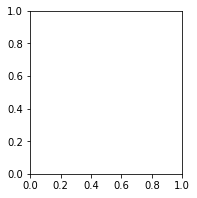

In [35]:
#@title Visualize the outputs { run: "auto" }
index = 2 #@param {type:"slider", min:0, max:9, step:1}
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(index, predictions, test_labels, test_imgs)
plt.show()

In [31]:
labels = ['cat', 'dog']

with open('labels.txt', 'w') as f:
  f.write('\n'.join(labels))

try:
  from google.colab import files
  files.download('converted_model.tflite')
  files.download('labels.txt')
except:
  pass

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Prepare the test images for download

In [32]:
!mkdir -p test_images

In [33]:
from PIL import Image

for index, (image, label) in enumerate(test_batches.take(50)):
  image = tf.cast(image * 255.0, tf.uint8)
  image = tf.squeeze(image).numpy()
  pil_image = Image.fromarray(image)
  pil_image.save('test_images/{}_{}.jpg'.format(class_names[label[0]], index))

NameError: ignored